<a href="https://colab.research.google.com/github/LomanovAY/colab/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузка данных
df = pd.read_csv('/content/realtor-data.csv', low_memory=False)
print(f"Размер датасета: {df.shape}")
print(df.head())

Размер датасета: (2226382, 12)
   brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   

         city        state  zip_code  house_size prev_sold_date  
0    Adjuntas  Puerto Rico     601.0       920.0            NaN  
1    Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2  Juana Diaz  Puerto Rico     795.0       748.0            NaN  
3       Ponce  Puerto Rico     731.0      1800.0            NaN  
4    Mayaguez  Puerto Rico     680.0         NaN            NaN  


In [3]:
# первичный анализ данных

# Основная информация
print(df.info())
# Статистика
print(df.describe())
# Пропуски
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB
None
        brokered_by         price           bed          bath      acre_lot  \
count  2.221849e+06  2.224841e+06  1.745065e+06  1.714611e+06  1.900793e+06   
mean   5.293989e+04  5.241955e+05  3.275841e+00  2.496440e+00  1.522303e+01   
std    3.064275e+04  2.138893e+06  1.567274e+00  1.652573e+00  7.628238e+02   
min    0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    2.386100e+04  1.6500

,0
brokered_by,4533
status,0
price,1541
bed,481317
bath,511771
acre_lot,325589
street,10866
city,1407
state,8
zip_code,299


In [4]:
# предобработка данных
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Копия данных для безопасности
df_clean = df.copy()

# Удаление дубликатов
initial_rows = len(df_clean)
df_clean = df_clean.drop_duplicates()

# Обработка пропусков в ключевых числовых признаках
# Удаление записей с пропусками в ключевых полях
key_columns = ['price', 'bed', 'bath', 'house_size']
df_clean = df_clean.dropna(subset=key_columns)

# Для acre_lot используем медиану по штату
if 'acre_lot' in df_clean.columns:
    df_clean['acre_lot'] = df_clean.groupby('state')['acre_lot'].transform(
        lambda x: x.fillna(x.median())
    )
    # Если в группе все NaN, заполняем общей медианой
    df_clean['acre_lot'] = df_clean['acre_lot'].fillna(df_clean['acre_lot'].median())

# Для prev_sold_date - создаем флаг
df_clean['has_prev_sold'] = df_clean['prev_sold_date'].notna().astype(int)
df_clean = df_clean.drop('prev_sold_date', axis=1)

# Обработка выбросов
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Обрабатываем основные числовые признаки
numeric_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
initial_size = len(df_clean)

for col in numeric_cols:
    if col in df_clean.columns:
        df_clean = remove_outliers_iqr(df_clean, col)

# Создаем целевую переменную
median_price = df_clean['price'].median()
df_clean['is_expensive'] = (df_clean['price'] > median_price).astype(int)

# Создание дополнительных признаков

# Цена за квадратный фут
df_clean['price_per_sqft'] = df_clean['price'] / df_clean['house_size']
df_clean['price_per_sqft'] = df_clean['price_per_sqft'].replace([np.inf, -np.inf], np.nan)
df_clean['price_per_sqft'] = df_clean['price_per_sqft'].fillna(df_clean['price_per_sqft'].median())

# Соотношение ванных к спальням
df_clean['bath_bed_ratio'] = df_clean['bath'] / df_clean['bed']
df_clean['bath_bed_ratio'] = df_clean['bath_bed_ratio'].replace([np.inf, -np.inf], np.nan)
df_clean['bath_bed_ratio'] = df_clean['bath_bed_ratio'].fillna(df_clean['bath_bed_ratio'].median())

# Площадь на спальню
df_clean['sqft_per_bed'] = df_clean['house_size'] / df_clean['bed']
df_clean['sqft_per_bed'] = df_clean['sqft_per_bed'].replace([np.inf, -np.inf], np.nan)
df_clean['sqft_per_bed'] = df_clean['sqft_per_bed'].fillna(df_clean['sqft_per_bed'].median())

print(f"Размер датафрейма после очистки: {df_clean.shape}")

Размер датафрейма после очистки: (1132560, 16)


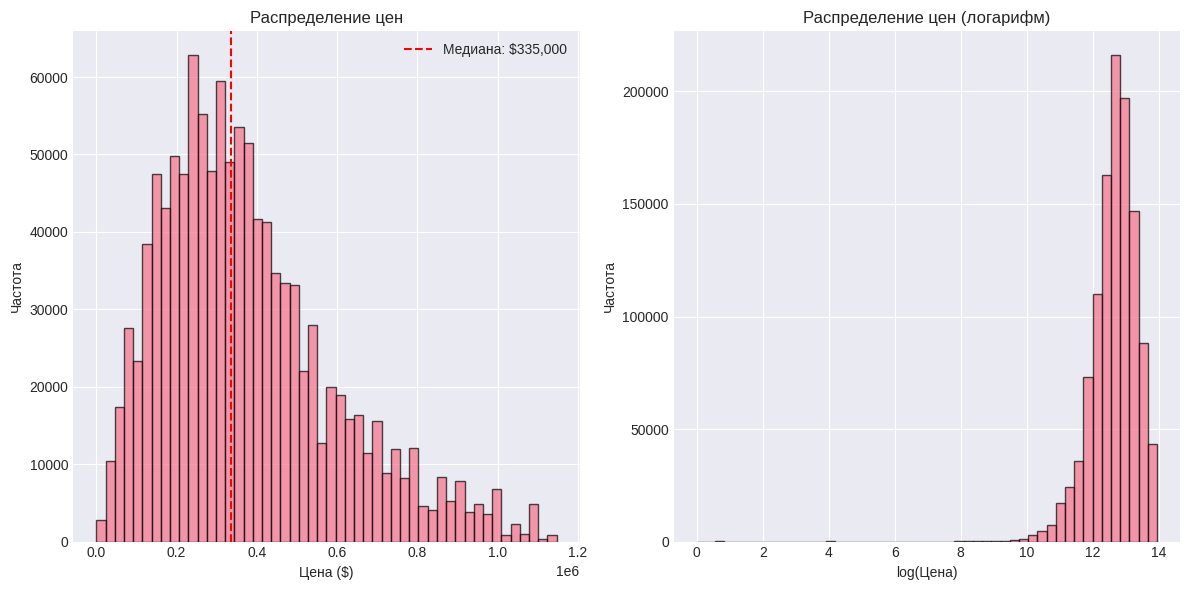

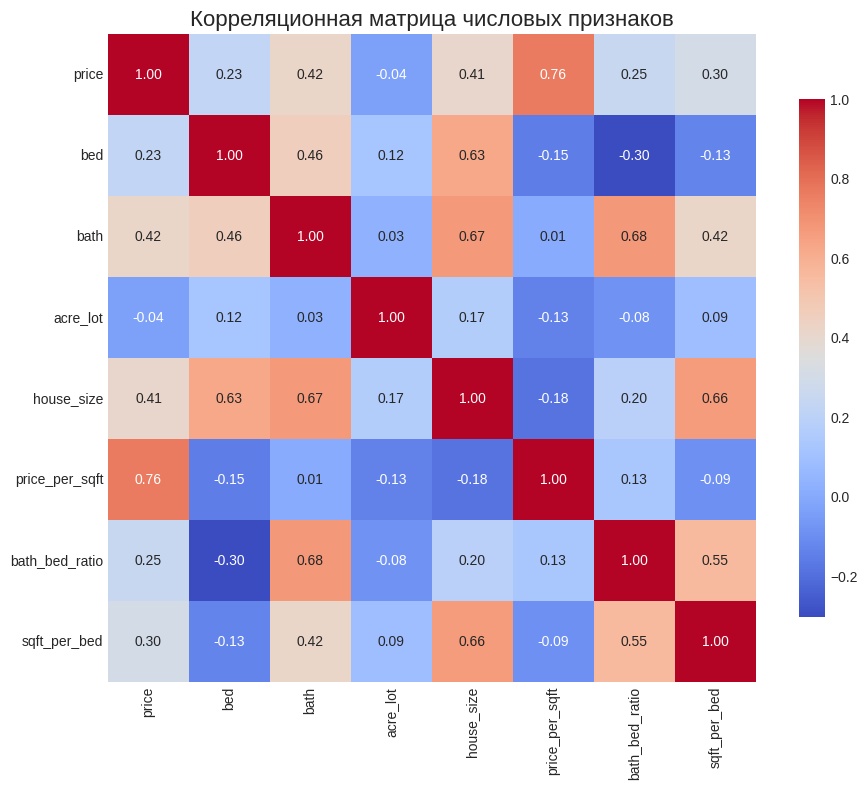

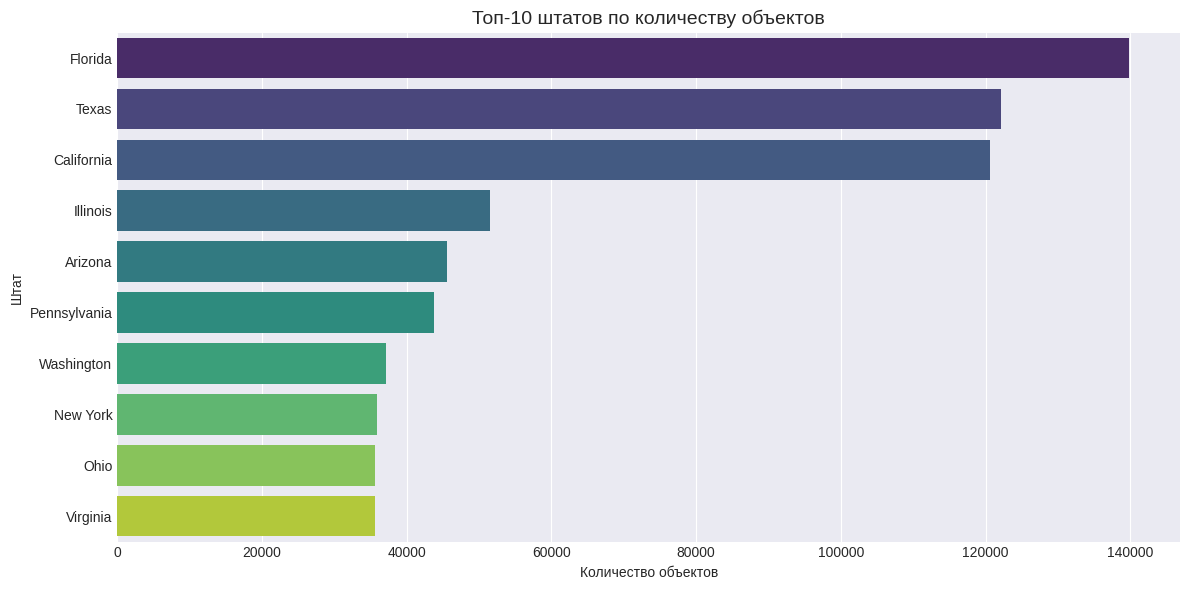

In [5]:
# визуализация данных
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Распределение цен
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df_clean['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен')
plt.xlabel('Цена ($)')
plt.ylabel('Частота')
plt.axvline(median_price, color='red', linestyle='--', label=f'Медиана: ${median_price:,.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.log1p(df_clean['price']), bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение цен (логарифм)')
plt.xlabel('log(Цена)')
plt.ylabel('Частота')
plt.tight_layout()
plt.savefig('price_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Корреляционная матрица
numeric_features = ['price', 'bed', 'bath', 'acre_lot', 'house_size',
                    'price_per_sqft', 'bath_bed_ratio', 'sqft_per_bed']
corr_matrix = df_clean[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица числовых признаков', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Распределение по штатам (топ-10)
plt.figure(figsize=(12, 6))
top_states = df_clean['state'].value_counts().head(10)
sns.barplot(x=top_states.values, y=top_states.index, palette='viridis')
plt.title('Топ-10 штатов по количеству объектов', fontsize=14)
plt.xlabel('Количество объектов')
plt.ylabel('Штат')
plt.tight_layout()
plt.savefig('top_states.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# подготовка данных для моделирования
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Выберем признаки для модели
features = ['bed', 'bath', 'acre_lot', 'house_size', 'price_per_sqft',
            'bath_bed_ratio', 'sqft_per_bed', 'has_prev_sold']

# Добавим категориальные признаки
categorical_cols = ['state']
for col in categorical_cols:
    if col in df_clean.columns:
        # Берем только топ-20 категорий для уменьшения размерности
        top_categories = df_clean[col].value_counts().head(20).index
        df_clean[col] = df_clean[col].where(df_clean[col].isin(top_categories), 'Other')
        features.append(col)

# Разделим датасет на признаки и целевую переменную
X = df_clean[features].copy()
y = df_clean['is_expensive'].copy()

# Преобразуем категориальные признаки
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# Разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмеры выборок:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"\nРаспределение классов в train: {np.bincount(y_train)/len(y_train)}")
print(f"Распределение классов в test: {np.bincount(y_test)/len(y_test)}")


# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Размеры выборок:
X_train: (906048, 9), y_train: (906048,)
X_test: (226512, 9), y_test: (226512,)

Распределение классов в train: [0.50070747 0.49929253]
Распределение классов в test: [0.50070636 0.49929364]


МОДЕЛЬ: Logistic Regression
Accuracy: 0.9542
ROC-AUC: 0.9919

 ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95    113416
           1       0.96      0.95      0.95    113096

    accuracy                           0.95    226512
   macro avg       0.95      0.95      0.95    226512
weighted avg       0.95      0.95      0.95    226512



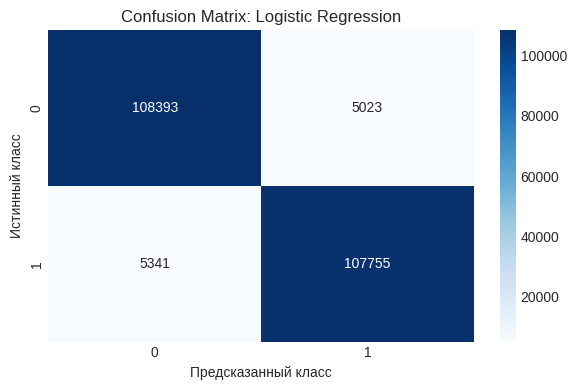

МОДЕЛЬ: Random Forest
Accuracy: 0.9992
ROC-AUC: 1.0000

 ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113416
           1       1.00      1.00      1.00    113096

    accuracy                           1.00    226512
   macro avg       1.00      1.00      1.00    226512
weighted avg       1.00      1.00      1.00    226512



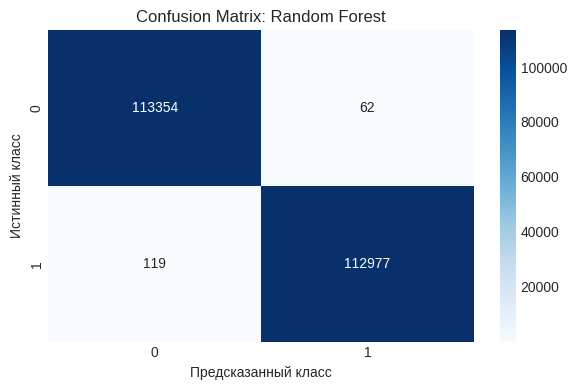

МОДЕЛЬ: XGBoost
Accuracy: 0.9991
ROC-AUC: 1.0000

 ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113416
           1       1.00      1.00      1.00    113096

    accuracy                           1.00    226512
   macro avg       1.00      1.00      1.00    226512
weighted avg       1.00      1.00      1.00    226512



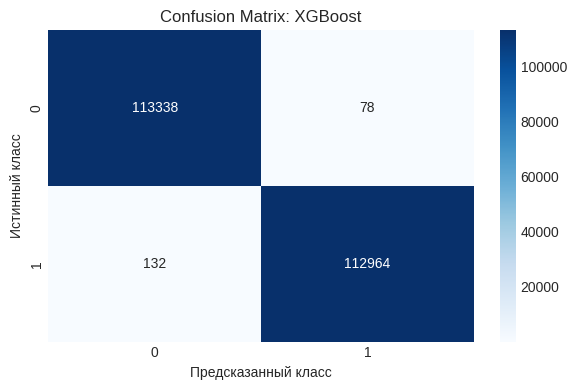

In [7]:
# моделирование
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False)
}

results = {}

for name, model in models.items():
    print(f"МОДЕЛЬ: {name}")

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Предсказания
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Оценка
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Сохранение результатов
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'roc_auc': roc_auc
    }

    # Детальный отчет для лучших моделей
    if roc_auc > 0.85:
        print("\n ОТЧЕТ КЛАССИФИКАЦИИ:")
        print(classification_report(y_test, y_pred))

        # Матрица ошибок
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {name}')
        plt.ylabel('Истинный класс')
        plt.xlabel('Предсказанный класс')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
        plt.show()


СРАВНИТЕЛЬНАЯ ТАБЛИЦА МОДЕЛЕЙ:
              Model  Accuracy  ROC-AUC
      Random Forest  0.999201 0.999996
            XGBoost  0.999073 0.999996
Logistic Regression  0.954245 0.991861


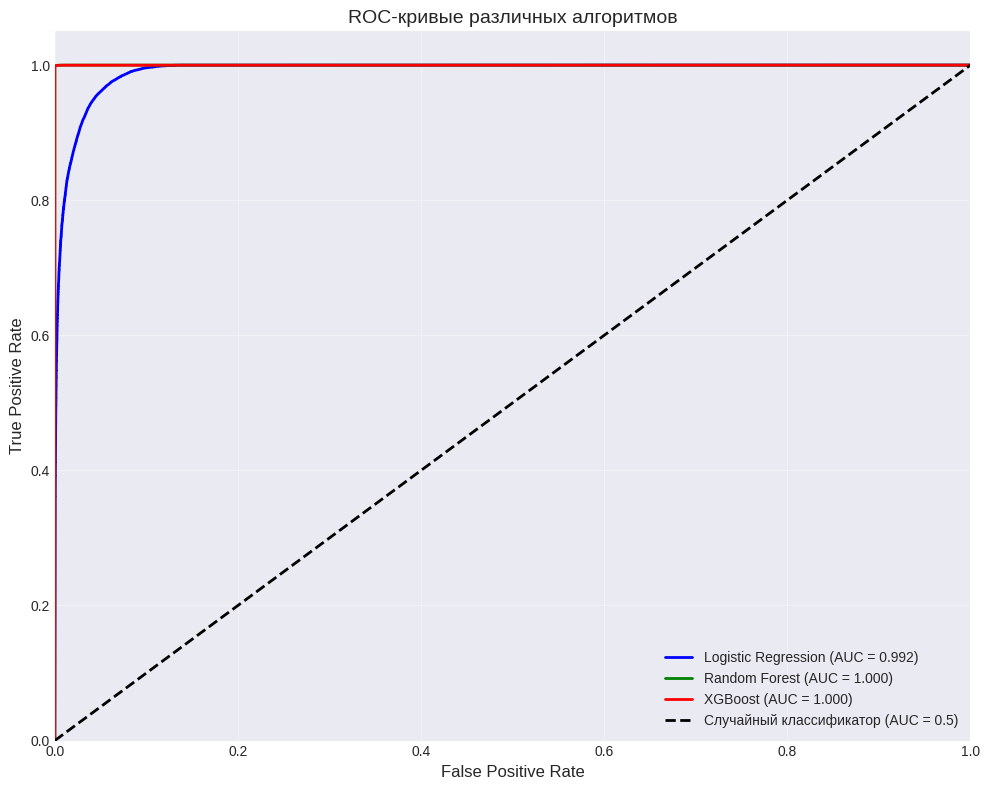

In [8]:
# сравним модели

# Таблица сравнения
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()]
}).sort_values('ROC-AUC', ascending=False)

print("\nСРАВНИТЕЛЬНАЯ ТАБЛИЦА МОДЕЛЕЙ:")
print(results_df.to_string(index=False))

# ROC-кривые
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red']
for (name, color) in zip(results.keys(), colors):
    y_pred_proba = results[name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = results[name]['roc_auc']

    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Случайный классификатор (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые различных алгоритмов', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()



ВАЖНОСТЬ ПРИЗНАКОВ

Топ-10 важнейших признаков по Random Forest:
       feature  Random Forest  XGBoost
price_per_sqft       0.610905 0.624317
    house_size       0.179968 0.367662
          bath       0.066536 0.000612
  sqft_per_bed       0.053967 0.002474
         state       0.044134 0.000791
           bed       0.024468 0.001128
bath_bed_ratio       0.015179 0.000773
      acre_lot       0.004132 0.000544
 has_prev_sold       0.000711 0.001700


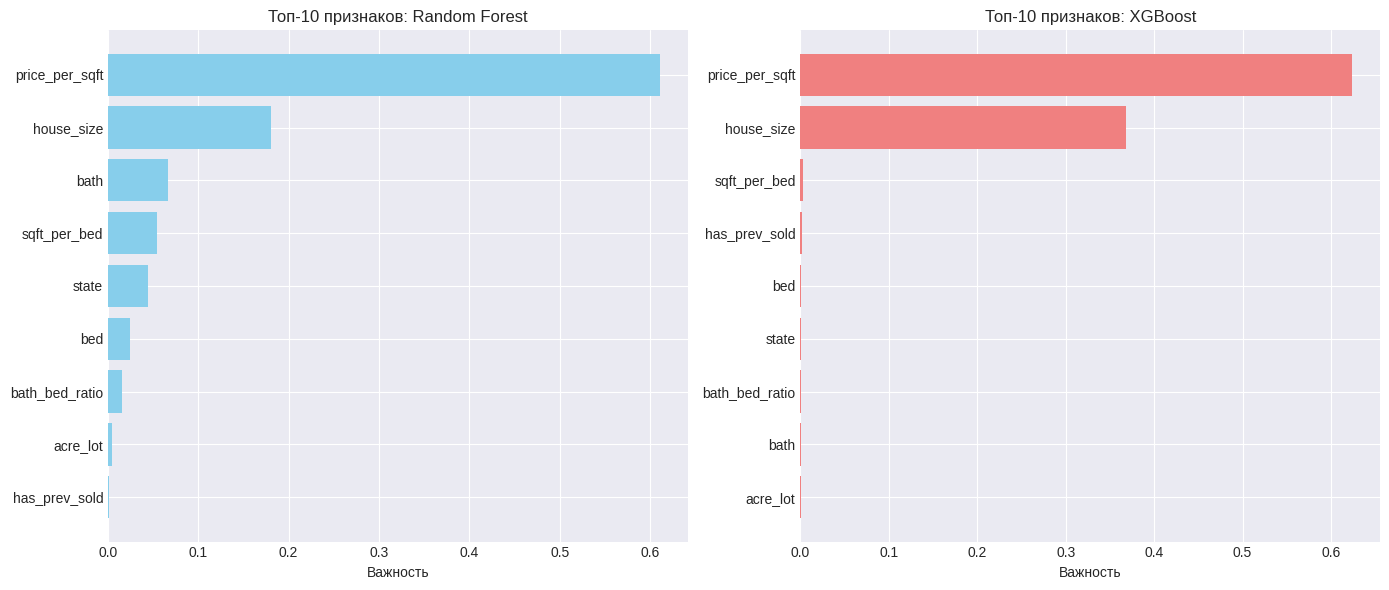

In [9]:
# Важность признаков для Random Forest и XGBoost
print("\nВАЖНОСТЬ ПРИЗНАКОВ")

feature_importance = pd.DataFrame({
    'feature': features,
    'Random Forest': results['Random Forest']['model'].feature_importances_,
    'XGBoost': results['XGBoost']['model'].feature_importances_
})

# Сортируем по важности в Random Forest
feature_importance = feature_importance.sort_values('Random Forest', ascending=False)

print("\nТоп-10 важнейших признаков по Random Forest:")
print(feature_importance.head(10).to_string(index=False))

# Визуализация важности признаков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (model_name, color) in enumerate([('Random Forest', 'skyblue'), ('XGBoost', 'lightcoral')]):
    top_features = feature_importance.nlargest(10, model_name)
    axes[idx].barh(range(len(top_features)), top_features[model_name], color=color)
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features['feature'])
    axes[idx].set_xlabel('Важность')
    axes[idx].set_title(f'Топ-10 признаков: {model_name}')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# кросс-валидация
print("\nКРОСС-ВАЛИДАЦИЯ")

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                cv=5, scoring='roc_auc', n_jobs=-1)
    print(f"\n{name}:")
    print(f"  ROC-AUC (кросс-валидация): {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Диапазон: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")


КРОСС-ВАЛИДАЦИЯ

Logistic Regression:
  ROC-AUC (кросс-валидация): 0.9918 (±0.0001)
  Диапазон: [0.9916, 0.9920]

Random Forest:
  ROC-AUC (кросс-валидация): 1.0000 (±0.0000)
  Диапазон: [1.0000, 1.0000]

XGBoost:
  ROC-AUC (кросс-валидация): 1.0000 (±0.0000)
  Диапазон: [1.0000, 1.0000]


In [11]:
# Выводы
best_model_name = results_df.iloc[0]['Model']
best_auc = results_df.iloc[0]['ROC-AUC']

print(f"\nЛучшая модель: {best_model_name} с ROC-AUC = {best_auc:.4f}")



Лучшая модель: Random Forest с ROC-AUC = 1.0000
